# Project 1 - Finding the lane lines

## Concepts learned:
* Region Masking
* Gaussian Blur
* Canny Edge detection
* Hough transform

## Action plan:
* Convert the image to grayscale
* Smoothen the edges using Gaussian blur
* Find the edges using Canny edge detector
* Mask the image
* Find lines using Hough transform
* Fit the points in a line and extrapolate the line

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


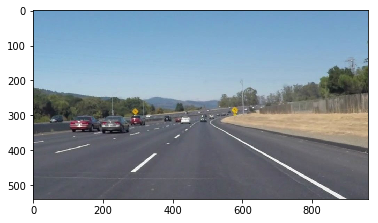

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Helper functions

Below are the helper functions which will be used for various transformations on the image to get the desired output. I have modified the function `draw_lines()`.
In the function `draw_lines()` ,line segments are seperated based on the slope to be categorised as a part of left line or right line. Then average of slope and intercept of left and right lines are calulated and based on that left and right lines are drawn.

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    right_slopes = []
    right_intercepts = []
    left_slopes = []
    left_intercepts = []
    left_points_x = []
    left_points_y = []
    right_points_x = []
    right_points_y = []
    
    y_max = img.shape[0]
    y_min = img.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)

            if slope < 0.0:
                left_slopes.append(slope) # left line
                left_points_x.append(x1)
                left_points_x.append(x2)
                left_points_y.append(y1)
                left_points_y.append(y2)
                left_intercepts.append(y1 - slope*x1)
            
            if slope > 0.0:
                right_slopes.append(slope) # right line
                right_points_x.append(x1)
                right_points_x.append(x2)
                right_points_y.append(y1)
                right_points_y.append(y2)
                right_intercepts.append(y1 - slope*x1)
            
            y_min = min(y1,y2,y_min)
            

            
    if len(left_slopes) > 0:
        left_slope = np.mean(left_slopes)
        left_intercept = np.mean(left_intercepts)
        x_min_left = int((y_min - left_intercept)/left_slope) 
        x_max_left = int((y_max - left_intercept)/left_slope)
        cv2.line(img, (x_min_left, y_min), (x_max_left, y_max), color, thickness)
    
    if len(right_slopes) > 0:
        right_slope = np.mean(right_slopes)
        right_intercept = np.mean(right_intercepts)
        x_min_right = int((y_min - right_intercept)/right_slope) 
        x_max_right = int((y_max - right_intercept)/right_slope)
        cv2.line(img, (x_min_right, y_min), (x_max_right, y_max),  color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

Let's test the image with the helper functions following the action plan by tweaking some input values to get the desired outcome.

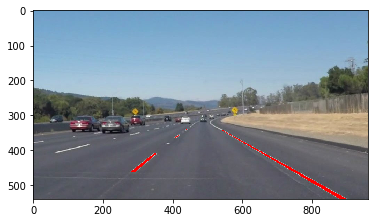

In [19]:
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [100, 539]
right_bottom = [900, 539]
apex = [500, 300]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
#plt.plot(x, y, 'b--', lw=4)
plt.imshow(color_select)
#cv2.imwrite('color_select.jpg',color_select)
plt.imshow(line_image)
#cv2.imwrite('line_image.jpg',cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
plt.show()

True

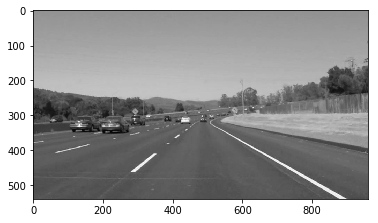

In [6]:
import cv2
gray_img = grayscale(image)
plt.imshow(gray_img, cmap='gray')

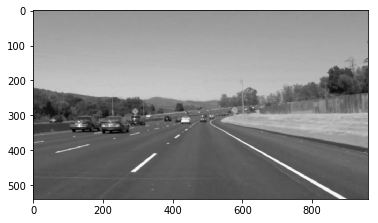

In [21]:
blurred_img = gaussian_blur(gray_img,kernel_size=5)
plt.imshow(blurred_img, cmap='gray')
plt.show()

I have decided to go with `kernel_size` as 5.

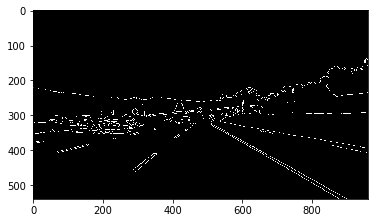

In [30]:
#apply canny edge detection
masked_edges = canny(blurred_img, low_threshold=50, high_threshold=150)
plt.imshow(masked_edges, cmap='gray')
plt.show()

I have masked the image in form of quadrilateral.The lower two vertices of this quadrilateral are the lower two endpoints of the image and the upper left vertex has dimension `[450,325]` and upper right vertex has dimension `[500,325]`.

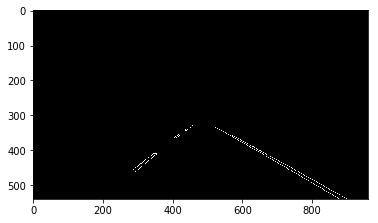

In [31]:
imshape = masked_edges.shape
vertices = np.array([[(30,imshape[0]),(450, 325), (500, 325), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(masked_edges,vertices)
plt.imshow(masked_image, cmap='gray')

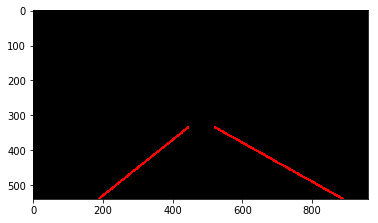

In [32]:
#apply hough transform on the image
rho = 2
theta = np.pi/180
threshold = 15
min_line_length = 30
max_line_gap = 10

# Run Hough on edge detected image
line_img = hough_lines(masked_image, rho, theta, threshold,
                            min_line_length, max_line_gap)
plt.imshow(line_img, cmap='gray')
plt.show()

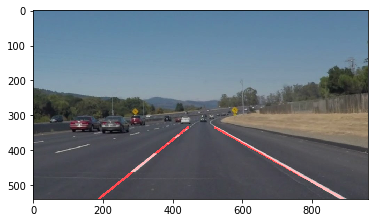

In [27]:
combo = weighted_img(line_img,image)
cv2.imwrite('final.jpg',cv2.cvtColor(combo, cv2.COLOR_BGR2RGB))
plt.imshow(combo)

In [11]:
def place_image_over(destination, source, x_offset=10, y_offset=10):
    '''
    Place given image on another image
    '''
    img = destination.copy()
    if len(source.shape) <= 2:
        img[y_offset:y_offset+source.shape[0], x_offset:x_offset+source.shape[1], 0] = source
        img[y_offset:y_offset+source.shape[0], x_offset:x_offset+source.shape[1], 1] = source
        img[y_offset:y_offset+source.shape[0], x_offset:x_offset+source.shape[1], 2] = source
    else:
        img[y_offset:y_offset+source.shape[0], x_offset:x_offset+source.shape[1]] = source
    return img

## Building the pipeline:
Below is the pipeline process defined as `pipeline`

* Convert the image to grayscale
* Smoothe the edges using Gaussian blur
* Find the edges using Canny edge detector
* Mask the image
* Find lines using Hough transform
* Fit the points in a line and extrapolate the line

In [12]:
def pipeline(image):
    '''
    Accepts an image as image and returns an image with lane lines drawn on it. 
    '''
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]
    color_select = np.copy(image)
    gray = grayscale(color_select)
    scale = 4
    gray_resized = cv2.resize(gray, (gray.shape[1]//scale, gray.shape[0]//scale), interpolation = cv2.INTER_AREA)

    blur_gray = gaussian_blur(gray,5)
    low_threshold = 50
    high_threshold = 150
    masked_edges = canny(blur_gray, low_threshold, high_threshold)
    masked_edges_resized = cv2.resize(masked_edges, (masked_edges.shape[1]//scale, masked_edges.shape[0]//scale), 
               interpolation = cv2.INTER_AREA)

    imshape = image.shape
    vertices = np.array([[(30,imshape[0]),(450, 325), (500, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(masked_edges,vertices)
    masked_image_resized = cv2.resize(masked_image, (masked_image.shape[1]//scale, masked_image.shape[0]//scale), 
               interpolation = cv2.INTER_AREA)
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 30
    max_line_gap = 10

    # Run Hough on edge detected image
    line_img = hough_lines(masked_image, rho, theta, threshold,
                                min_line_length, max_line_gap)
    line_img_resized = cv2.resize(line_img, (line_img.shape[1]//scale, line_img.shape[0]//scale), 
               interpolation = cv2.INTER_AREA)
    
    combo = weighted_img(line_img,image)
    print(gray_resized.shape)
    print(combo.shape)
    combo = place_image_over(combo,gray_resized,x_offset=10,y_offset=10)
    combo = place_image_over(combo,masked_edges_resized,x_offset=250,y_offset=10)
    combo = place_image_over(combo,masked_image_resized,x_offset=500,y_offset=10)
    combo = place_image_over(combo,line_img_resized,x_offset=700,y_offset=10)
    return combo
    

## Test the pipeline with images

Below code tests the images from `test_images` folder and saves the output of the pipeline into `test_images_output` folder.


(135, 240)
(540, 960, 3)


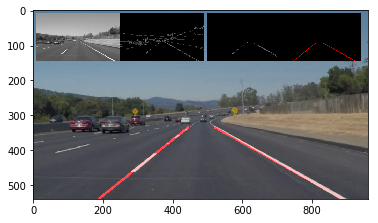

(135, 240)
(540, 960, 3)


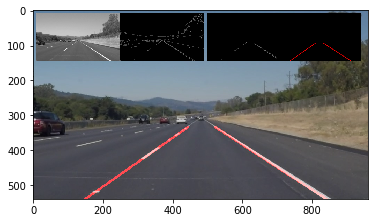

(135, 240)
(540, 960, 3)


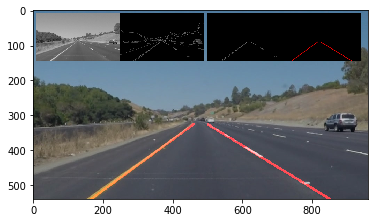

(135, 240)
(540, 960, 3)


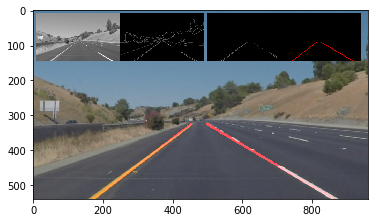

(135, 240)
(540, 960, 3)


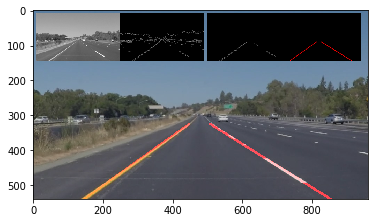

(135, 240)
(540, 960, 3)


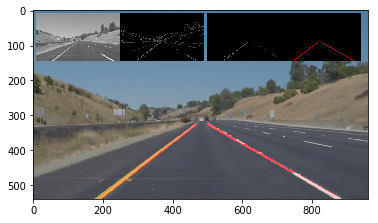

In [13]:
import os
image_names = os.listdir('test_images/')
for image_name in image_names:
    image = mpimg.imread('test_images/' + image_name)
    output_img = pipeline(image)
    plt.imshow(output_img)
    plt.show()
    output_img = cv2.cvtColor(output_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('test_images_output/' + image_name, output_img)

## Test pipeline with videos
Below code tests the pipeline for the videos in `test_videos` and stores the output in `test_videos_output`

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)
   
    return result

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Areas to improve:

* The image can be converted to HSL to find lane lines in different lighting conditions.
* Some frames might be bad and we might not be able to detect the lanes. To overcome this we can store the lines from previous frames and plot for the bad frame.